__Curate longitudinal dataset based on Ann-Kathrins pathology labels__

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode_paper/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import mne
import pandas as pd
import numpy as np

from braindecode.datasets.base import BaseDataset, BaseConcatDataset

from decode_tueg import extract_longitudinal_dataset, plot_longitudinal_interval_hists

Sat Nov 25 16:22:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B1:00.0 Off |                  N/A |
| 27%   25C    P8    21W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description.csv', index_col=0)
description.shape

(33660, 18)

In [3]:
description.reset_index(drop=True, inplace=True)

In [4]:
# correct paths to actual file locations
description = description.replace('/data/datasets/TUH/EEG/', '/home/jovyan/mne_data/TUH/', regex=True)

In [5]:
from decode_tueg import _reject_derivating_ages, _add_ages_from_additional_sources

In [6]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description_with_ages_updated_regex.csv', index_col=0)

In [7]:
def select_duration_and_age(df_, mins, clean_age):
    df_ = df_[df_.n_samples/df_.sfreq >= mins*60].reset_index(drop=True)
    if clean_age:
        ids = _reject_derivating_ages(df_)
        df_ = df_.loc[ids].reset_index(drop=True)
    return df_

In [8]:
description.shape

(33660, 20)

In [9]:
from decode_tueg import _load_longitudinal_dataset_from_df


def extract_longitudinal_dataset(description, kind=None, load=False):
    lnp, lp, lnpp, lpnp = [], [], [], []
    for s, g in description.groupby('subject'):
        # only interested in subjects with multiple recs
        if len(g) < 2:
            continue
        # all same label
        if g.pathological.nunique() == 1:
            if 0 in g.pathological.unique():
                lnp.append(g)
            if 1 in g.pathological.unique():
                lp.append(g)
        # label transition
        else:
            # keep 0 -> 1 only
            if all(g.pathological.diff()[1:] >= 0):
                lnpp.append(g)
            # keep 1 -> 0 only
            if all(g.pathological.diff()[1:] <= 0):
                lpnp.append(g)
    dfs = {'rnp': pd.concat(lnp), 'rp': pd.concat(lp), 'tnpp': pd.concat(lnpp), 'tpnp': pd.concat(lpnp)}
    if not load:
        if kind is None:
            return dfs
        else:
            return dfs[kind]
    else:
        if kind is None:
            return {ds_name: _load_longitudinal_dataset_from_df(df) for ds_name, df in dfs.items()}
        else: 
            return _load_longitudinal_dataset_from_df(dfs[kind])

In [10]:
for min_mins, clean_age in [(2, False), (15, False), (15, True)]:
    this_description = select_duration_and_age(description, min_mins, clean_age)
    dfs = extract_longitudinal_dataset(this_description, kind=None, load=False)
    print('recs', {ds_name: len(df) for ds_name, df in dfs.items()})
    print('subjects', {ds_name: df.subject.nunique() for ds_name, df in dfs.items()})    
    print()
    #for ds_name, df in dfs.items():
    #    df.to_csv(f'/home/jovyan/longitudinal/{ds_name}_{min_mins}_{clean_age}.csv')


recs {'rnp': 4068, 'rp': 18338, 'tnpp': 914, 'tpnp': 1273}
subjects {'rnp': 956, 'rp': 2892, 'tnpp': 195, 'tpnp': 242}

recs {'rnp': 933, 'rp': 5112, 'tnpp': 431, 'tpnp': 563}
subjects {'rnp': 372, 'rp': 1672, 'tnpp': 170, 'tpnp': 216}

recs {'rnp': 621, 'rp': 3963, 'tnpp': 330, 'tpnp': 347}
subjects {'rnp': 245, 'rp': 1321, 'tnpp': 133, 'tpnp': 136}



In [11]:
for ds_name, df in dfs.items():
    print(ds_name)
    print(df.shape)
    print('n subjects', df.subject.nunique())
    print(df.value_counts('pathological'))
    print(df.groupby('subject').head(1).value_counts('gender'))
    print('no age from reports', df['report_age'].isna().sum(), df['report_age'].isna().sum()/len(df))
    print()


rnp
(621, 20)
n subjects 245
pathological
0    621
dtype: int64
gender
F    135
M    110
dtype: int64
no age from reports 0 0.0

rp
(3963, 20)
n subjects 1321
pathological
1    3963
dtype: int64
gender
M    664
F    657
dtype: int64
no age from reports 0 0.0

tnpp
(330, 20)
n subjects 133
pathological
1    183
0    147
dtype: int64
gender
F    68
M    65
dtype: int64
no age from reports 0 0.0

tpnp
(347, 20)
n subjects 136
pathological
1    187
0    160
dtype: int64
gender
F    76
M    60
dtype: int64
no age from reports 0 0.0



In [12]:
import pickle

In [13]:
min_mins, clean_age

(15, True)

In [ ]:
for ds_name, df in dfs.items():
    ds = _load_longitudinal_dataset_from_df(df)
    with open(f'/home/jovyan/longitudinal/{ds_name}_{min_mins}_{clean_age}.pkl', 'wb') as f:
        pickle.dump(ds, f)

/home/jovyan/tueg_age_decoding/decode_tueg.py:3166: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, s in dfs.iteritems():
/home/jovyan/tueg_age_decoding/decode_tueg.py:3166: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, s in dfs.iteritems():


In [14]:
description.shape

(33660, 20)

In [15]:
for df_name, df in dfs.items():
    for s in df.subject.unique():
        description.drop(description[description.subject==s].index, axis=0, inplace=True)

In [16]:
description.shape

(20896, 20)

In [19]:
lnp = dfs['rnp']
lp = dfs['rp']
lnpp = dfs['tnpp']
lpnp = dfs['tpnp']

In [20]:
np.intersect1d(description.subject, lnp.subject)

array([], dtype=int64)

In [21]:
np.intersect1d(description.subject, lp.subject)

array([], dtype=int64)

In [22]:
np.intersect1d(description.subject, lnpp.subject)

array([], dtype=int64)

In [23]:
np.intersect1d(description.subject, lpnp.subject)

array([], dtype=int64)

In [24]:
description.shape

(20896, 20)

In [25]:
description = select_duration_and_age(description, 15, True)

In [26]:
description.shape

(7657, 20)

In [27]:
(description.groupby('subject').size() > 1).sum()

33

In [58]:
np.random.seed(20230726)
ids_lnp = np.random.choice(range(len(description)), len(lnp), replace=False)
sampled_df_lnp = description.iloc[ids_lnp].copy()
sampled_df_lnp.sort_values(['year', 'month', 'day', 'session', 'segment'], inplace=True)
sampled_df_lnp.shape, sampled_df_lnp.subject.nunique()

((621, 20), 619)

In [59]:
np.random.seed(20230726)
ids_lp = np.random.choice(range(len(description)), len(lp), replace=False)
sampled_df_lp = description.iloc[ids_lp].copy()
sampled_df_lp.sort_values(['year', 'month', 'day', 'session', 'segment'], inplace=True)
sampled_df_lp.shape, sampled_df_lp.subject.nunique()

((3963, 20), 3933)

In [60]:
np.random.seed(20230726)
ids_lnpp = np.random.choice(range(len(description)), len(lnpp), replace=False)
sampled_df_lnpp = description.iloc[ids_lnpp].copy()
sampled_df_lnpp.sort_values(['year', 'month', 'day', 'session', 'segment'], inplace=True)
sampled_df_lnpp.shape, sampled_df_lnpp.subject.nunique()

((330, 20), 330)

In [61]:
np.random.seed(20230726)
ids_lpnp = np.random.choice(range(len(description)), len(lpnp), replace=False)
sampled_df_lpnp = description.iloc[ids_lpnp].copy()
sampled_df_lpnp.sort_values(['year', 'month', 'day', 'session', 'segment'], inplace=True)
sampled_df_lpnp.shape, sampled_df_lpnp.subject.nunique()

((347, 20), 347)

In [62]:
min_mins, clean_age

(15, True)

In [63]:
# save sampled datasets for comparisons to disk

In [28]:
from decode_tueg import age_pyramid, save_fig

Sun Nov 26 07:06:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B1:00.0 Off |                  N/A |
| 27%   25C    P8    21W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

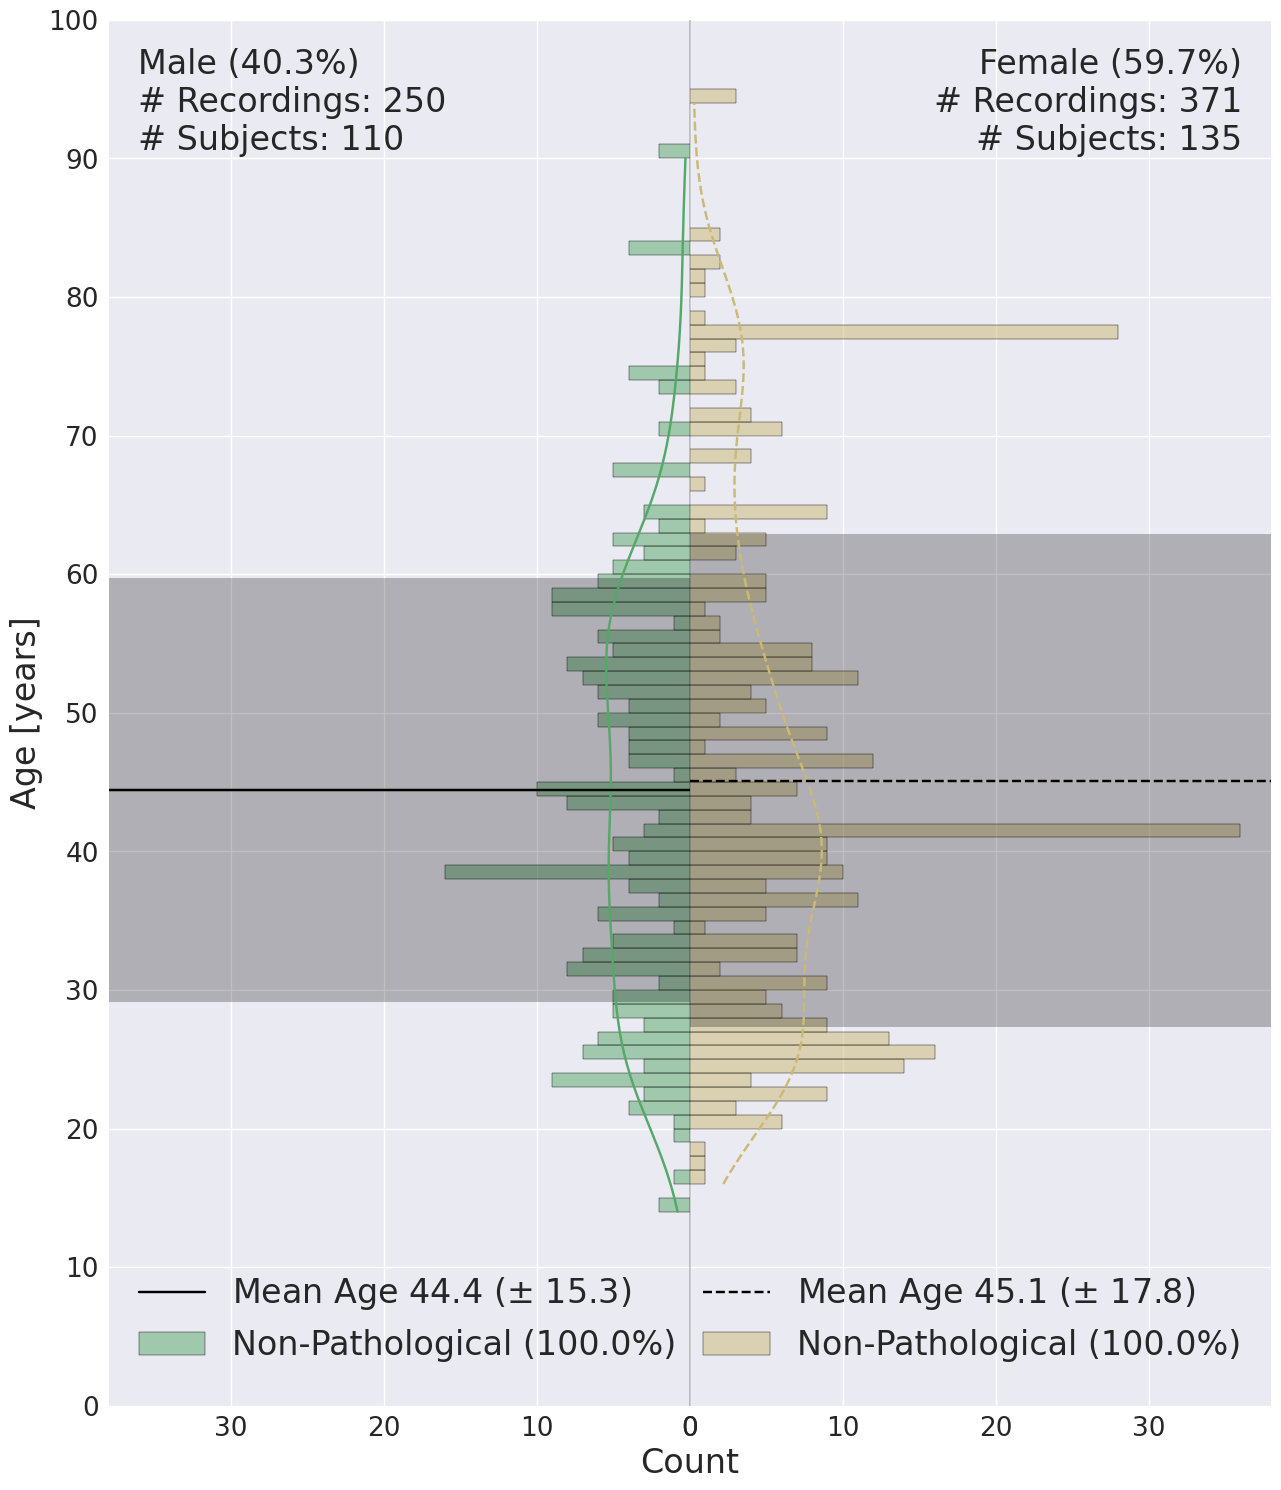

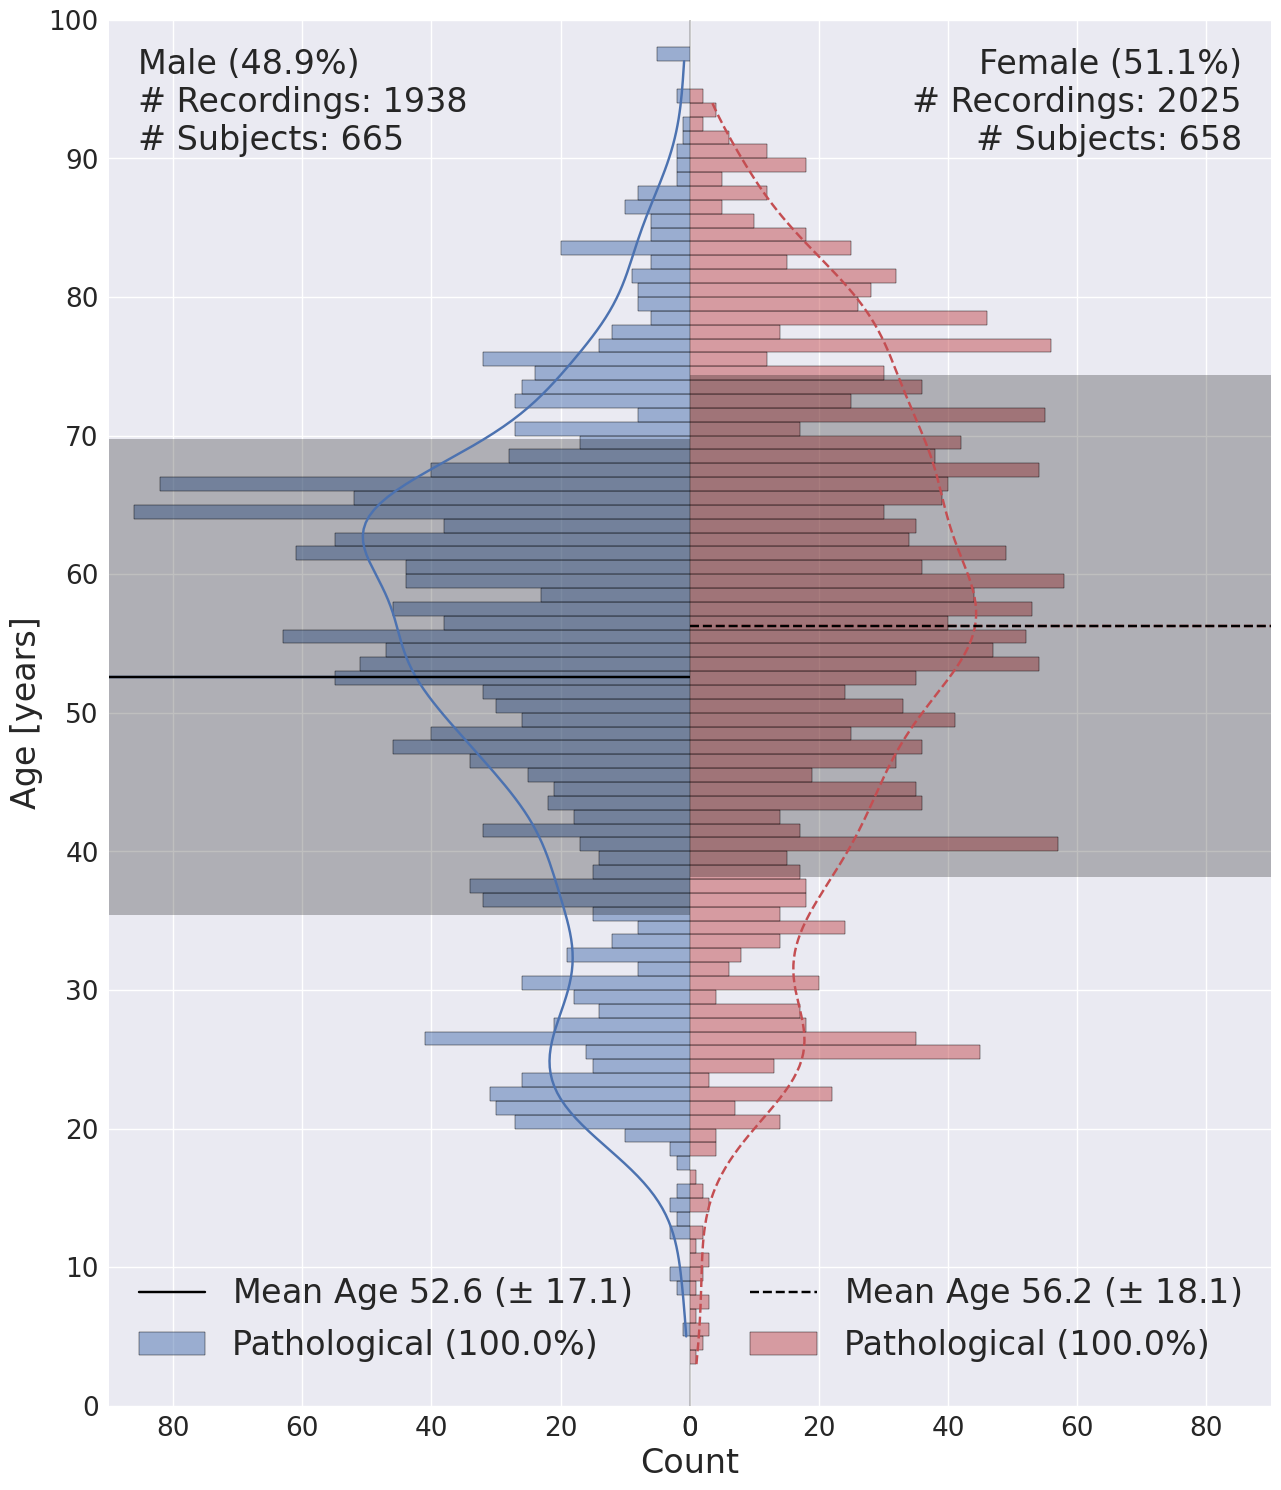

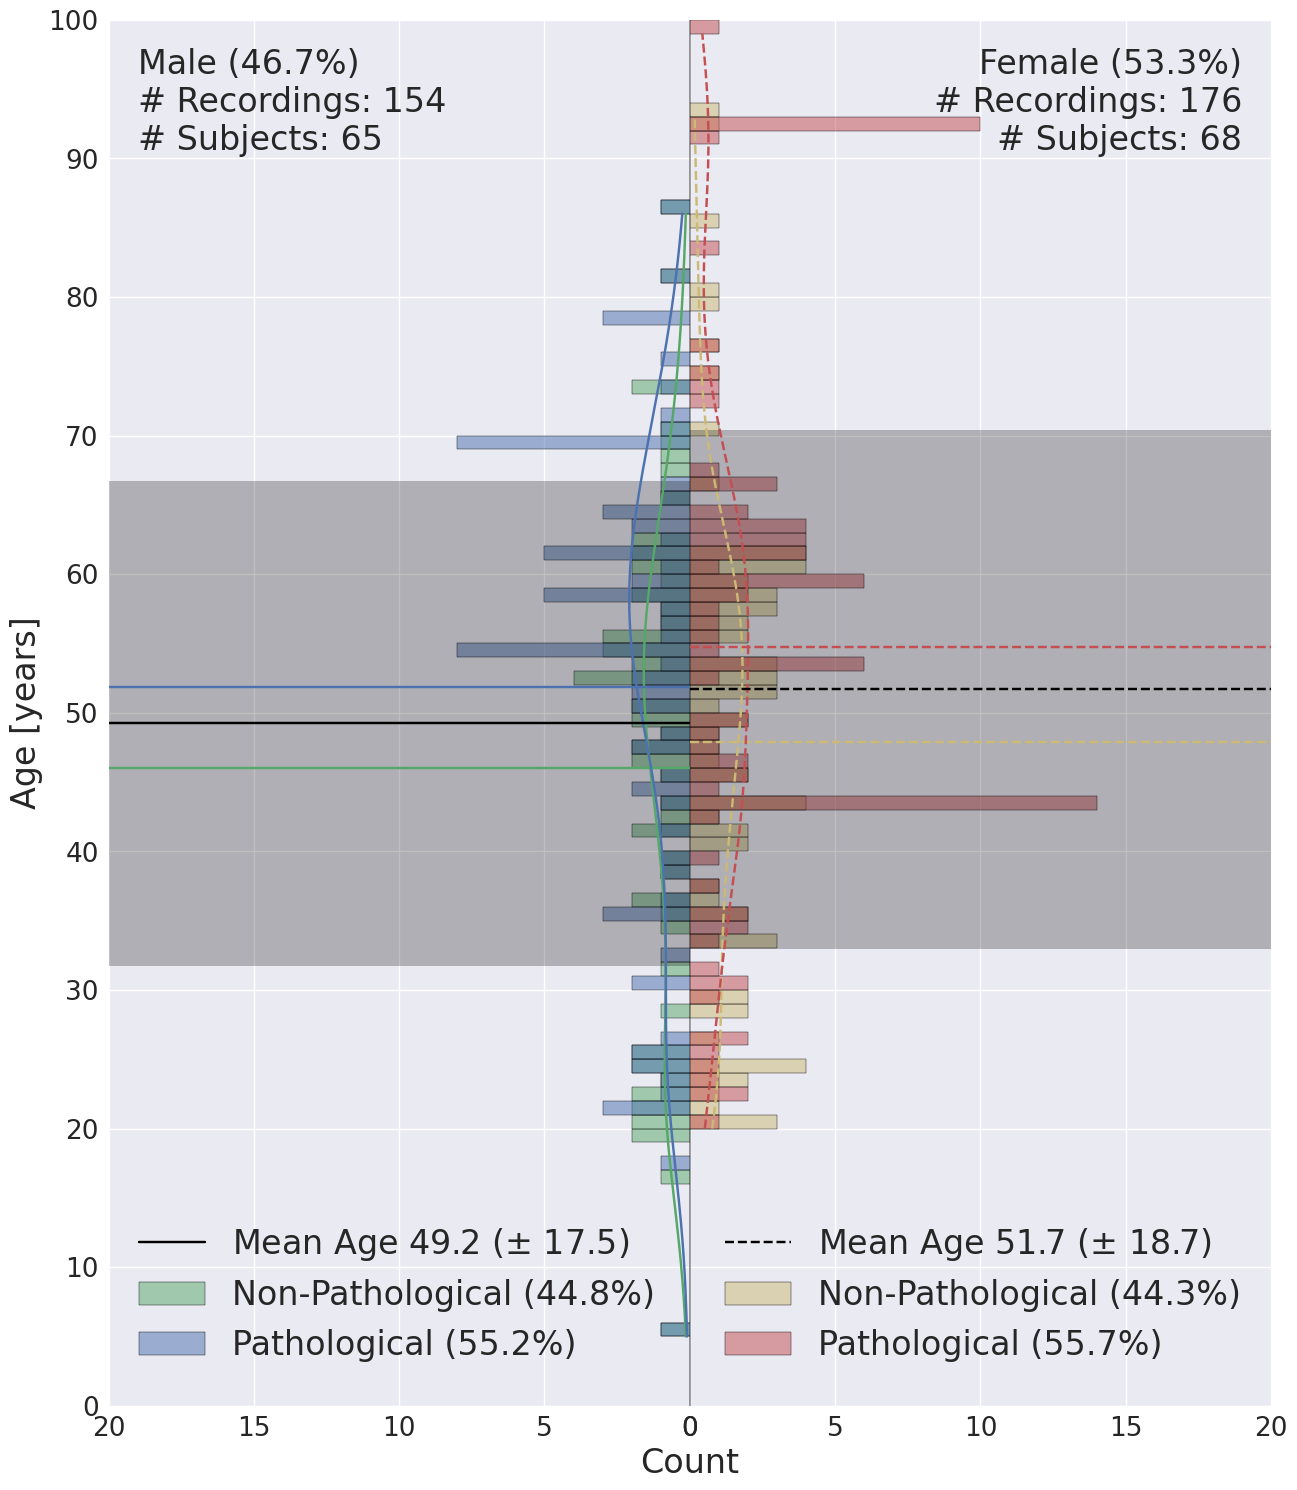

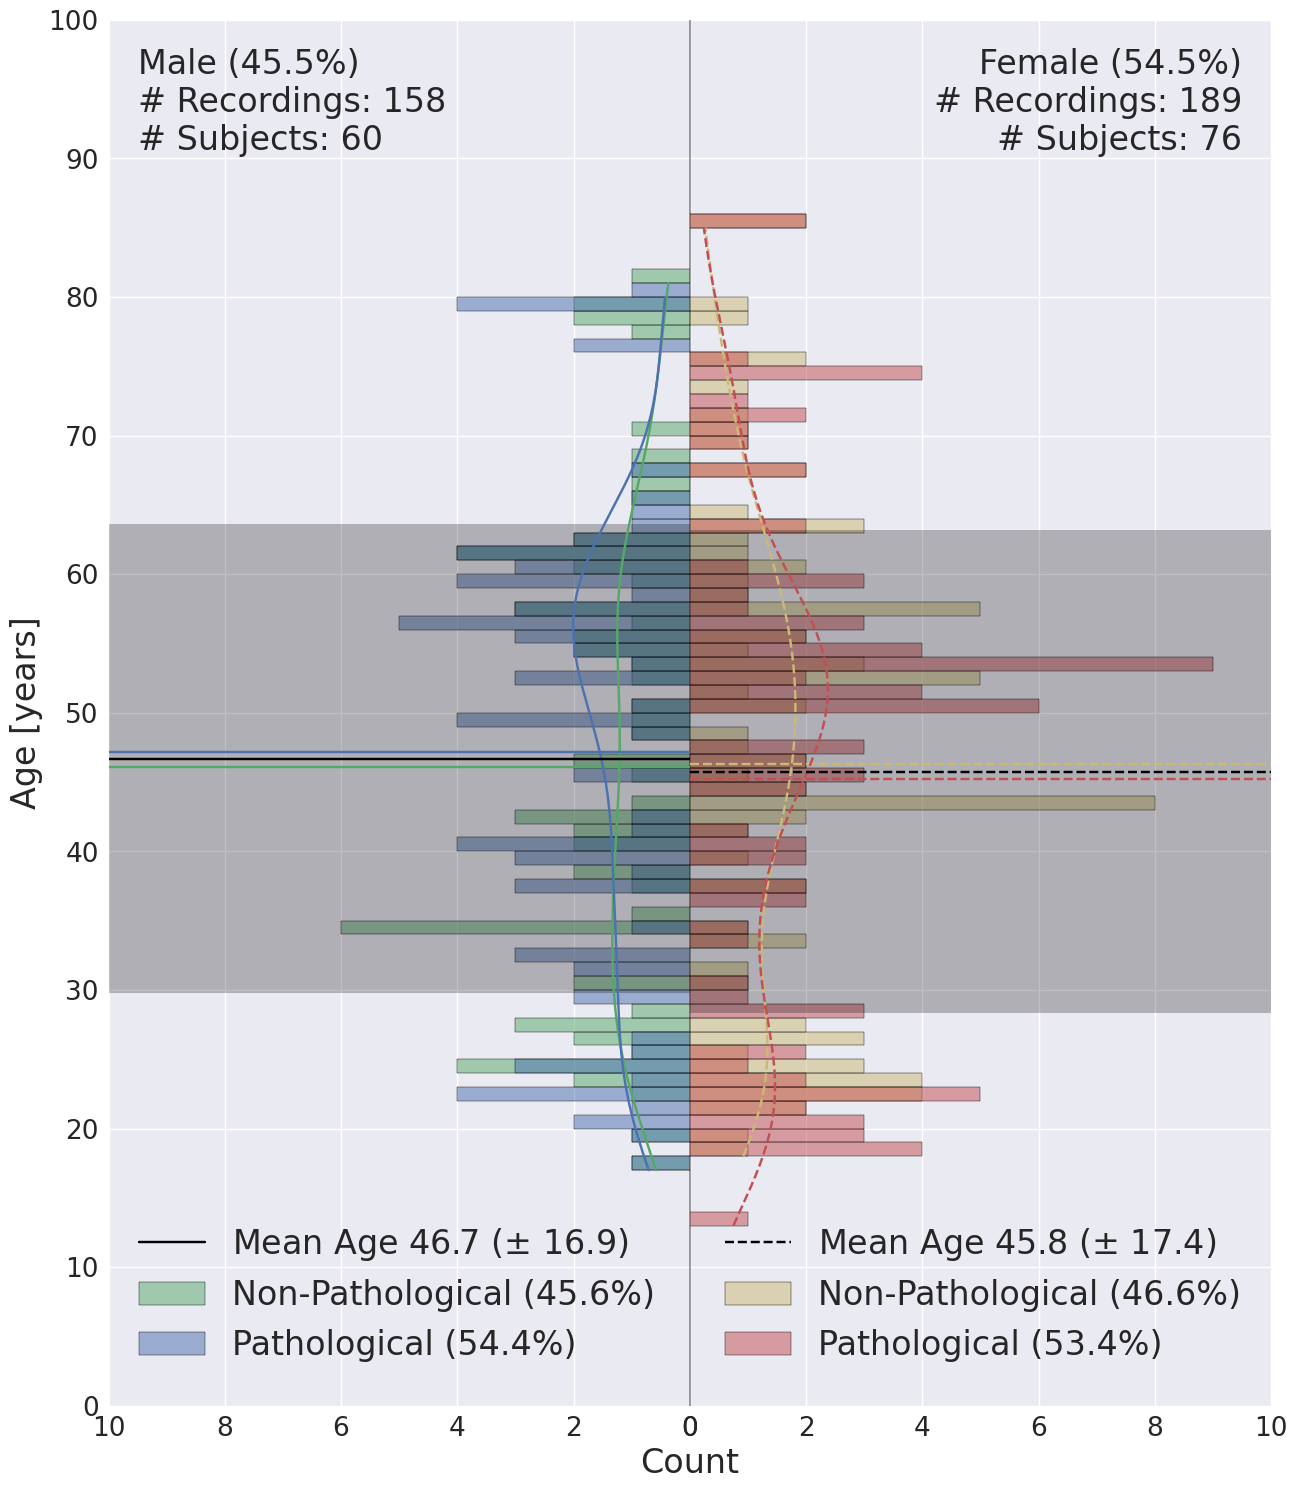

In [202]:
for ds_name, ds, ylim in [('rnp', lnp, 38), ('rp', lp, 90), ('tnpp', lnpp, 20), ('tpnp', lpnp, 10)]:
    ax_arr = age_pyramid(ds, '', show_title=False, ylim=ylim)
    #save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', f'age_pyramid_{ds_name}_{min_mins}_{clean_age}')

In [239]:
for ds_name, ds, ylim in [('rnp', lnp, 38), ('rp', lp, 90), ('tnpp', lnpp, 20), ('tpnp', lpnp, 10)]:
    ds.reset_index(inplace=True)
    print(ds_name, ds[ds.report.str.findall('schizo').str.len() != 0].shape)


rnp (11, 22)
rp (47, 21)
tnpp (1, 21)
tpnp (7, 21)


# plot recording durations and intervals

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
def plot_recording_durations(all_rec_preds_, palette, tmax=30, stepsize=1, ax=None):
    all_rec_preds = all_rec_preds_.copy() 
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,3))
    all_rec_preds.duration.clip(upper=tmax*60, inplace=True)
    bins = [t*60 for t in range(2, tmax+1, stepsize)]
    ax = sns.histplot(
        data=all_rec_preds,
        x='duration',
        hue='Dataset',
        palette=palette,
        bins=bins,
        multiple='stack',
        alpha=.5,
        ax=ax,
        log_scale=(False, True),
    )
    ax.set_xlabel('Duration [min]')
    tick_bins = [t for t in [2, 5, 10, 15, 20, 25, 30]]
    ax.set_xticks([t*60 for t in tick_bins]);
    ax.set_xticklabels([f'{t}' for t in tick_bins]);
    return ax

In [32]:
import pandas as pd

In [33]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description_with_ages_updated_regex.csv', index_col=0)

In [34]:
description['duration'] = description.n_samples / description.sfreq

In [35]:
save_figures = False

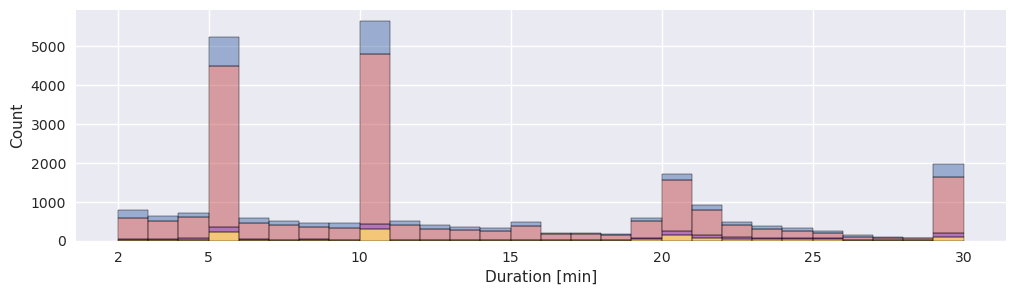

In [98]:
this_description = select_duration_and_age(description, mins=2, clean_age=False)
dfs = extract_longitudinal_dataset(this_description, kind=None, load=False)
all_datasets = []
for ds_name, df in dfs.items():
    df['Dataset'] = ds_name.upper()
    all_datasets.append(df)
ax = plot_recording_durations(pd.concat(all_datasets), palette=['b', 'r', 'purple', 'orange'])
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', 'longitudinal_recording_durations')

In [99]:
palette={'rnp': 'b', 'rp': 'r', 'tnpp': 'purple', 'tpnp': 'orange'}

In [122]:
save_figures = False

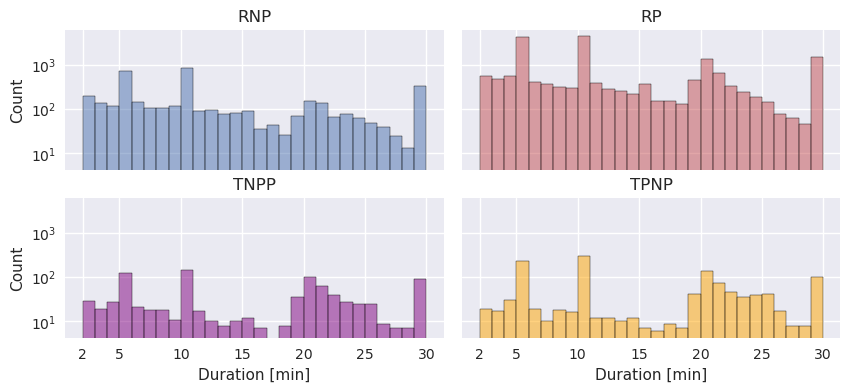

In [121]:
fig, ax_arr = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
for i, (ds_name, df) in enumerate(dfs.items()):
    ax = ax_arr[i//2][i%2]
    ax = plot_recording_durations(all_rec_preds_=df, palette=[palette[ds_name]], ax=ax)
    ax.set_title(ds_name.upper())
    ax.legend()
    plt.subplots_adjust(wspace=.05)
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', 'longitudinal_recording_durations')


In [181]:
bins = np.arange(0, 105, 5, dtype=int)

In [183]:
# subjects averaged
ss = []
for ds_name, df in dfs.items():
    s = df.groupby('subject').mean(numeric_only=True).age.value_counts(bins=bins, sort=False)
    s.index=bins[1:]
    s.name = ds_name
    ss.append(s)

In [184]:
print(pd.DataFrame(ss).T.to_csv())

,rnp,rp,tnpp,tpnp
5,57,54,2,2
10,14,27,1,2
15,12,27,0,1
20,42,45,4,8
25,94,117,19,29
30,92,127,16,24
35,61,114,12,21
40,79,130,8,17
45,90,198,16,19
50,93,235,13,26
55,93,301,27,27
60,73,324,22,20
65,52,333,24,12
70,38,252,9,13
75,29,206,7,5
80,11,171,7,8
85,13,137,4,5
90,7,65,2,3
95,6,17,1,0
100,0,4,1,0



In [183]:
# recordings
ss = []
for ds_name, df in dfs.items():
    s = df..age.value_counts(bins=bins, sort=False)
    s.index=bins[1:]
    s.name = ds_name
    ss.append(s)

In [184]:
print(pd.DataFrame(ss).T.to_csv())

,rnp,rp,tnpp,tpnp
5,57,54,2,2
10,14,27,1,2
15,12,27,0,1
20,42,45,4,8
25,94,117,19,29
30,92,127,16,24
35,61,114,12,21
40,79,130,8,17
45,90,198,16,19
50,93,235,13,26
55,93,301,27,27
60,73,324,22,20
65,52,333,24,12
70,38,252,9,13
75,29,206,7,5
80,11,171,7,8
85,13,137,4,5
90,7,65,2,3
95,6,17,1,0
100,0,4,1,0



In [185]:
from datetime import datetime

In [186]:
from decode_tueg import plot_n_recs_per_subject, plot_rec_intervals

In [200]:
save_figures = True

recs {'rnp': 4068, 'rp': 18338, 'tnpp': 914, 'tpnp': 1273}
subjects {'rnp': 956, 'rp': 2892, 'tnpp': 195, 'tpnp': 242}

recs {'rnp': 933, 'rp': 5112, 'tnpp': 431, 'tpnp': 563}
subjects {'rnp': 372, 'rp': 1672, 'tnpp': 170, 'tpnp': 216}

recs {'rnp': 621, 'rp': 3963, 'tnpp': 330, 'tpnp': 347}
subjects {'rnp': 245, 'rp': 1321, 'tnpp': 133, 'tpnp': 136}



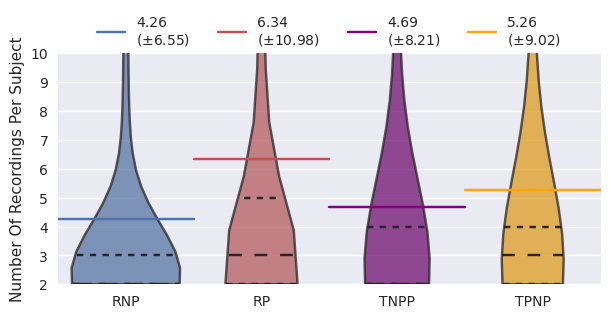

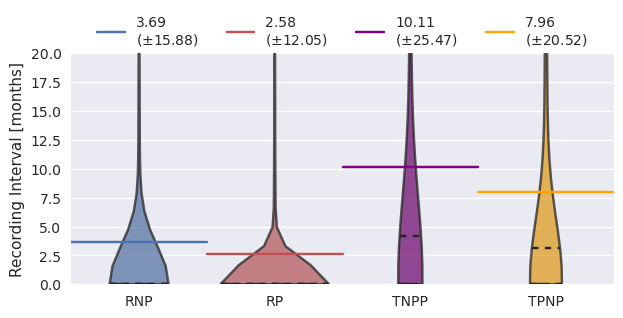

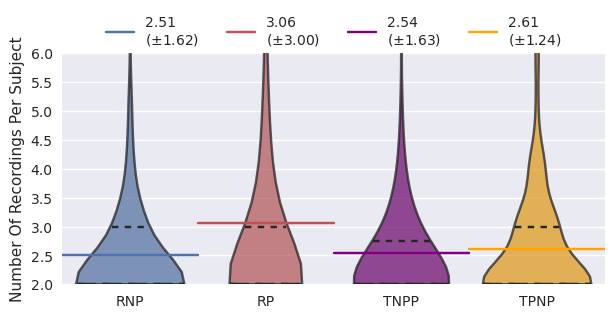

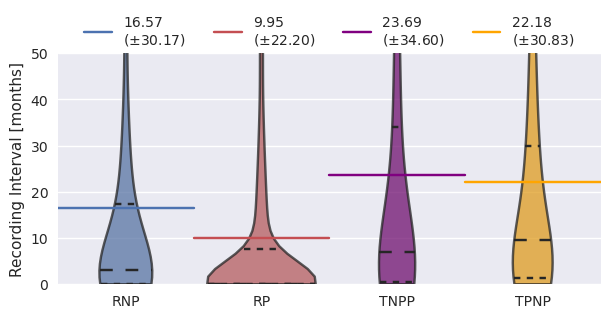

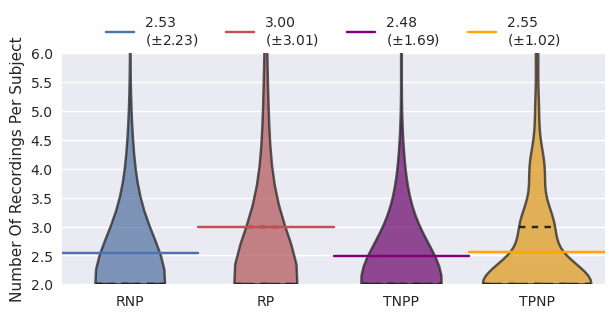

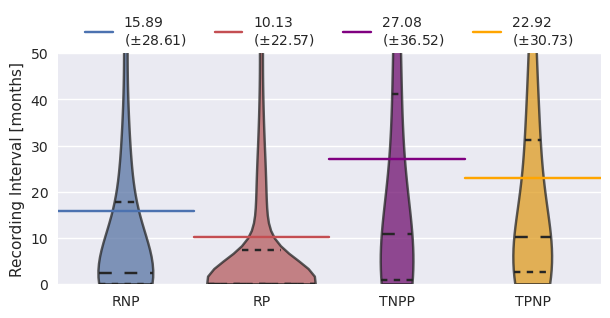

In [201]:
for min_mins, clean_age in [(2, False), (15, False), (15, True)]:
    this_description = select_duration_and_age(description, min_mins, clean_age)
    dfs = extract_longitudinal_dataset(this_description, kind=None, load=False)
    print('recs', {ds_name: len(df) for ds_name, df in dfs.items()})
    print('subjects', {ds_name: df.subject.nunique() for ds_name, df in dfs.items()})    
    print()
    #for ds_name, df in dfs.items():
    #    df.to_csv(f'/home/jovyan/longitudinal/{ds_name}_{min_mins}_{clean_age}.csv')
    
    n_recs_per_subject = []
    for ds_name, df in dfs.items():
        df['Dataset'] = ds_name.upper()
        n_recs_per_subject.append(df.groupby(['Dataset', 'subject'], as_index=False).size())
    n_recs_per_subject = pd.concat(n_recs_per_subject)
    ax = plot_n_recs_per_subject(n_recs_per_subject)
    if min_mins == 2:
        ax.set_ylim(2, 10)
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'n_recs_per_subject_{min_mins}_{clean_age}')
        
        
    day_diffs = []
    for ds_name, df in dfs.items():
        for subj, group in df.groupby('subject'):
            dates = [datetime(y, m, d) for i, (y, m, d) in group[['year', 'month', 'day']].iterrows()]
            for i in range(1, len(dates)):
                day_diffs.append((ds_name.upper(), (dates[i] - dates[i-1]).days/30, subj))
    y = 'Interval [months]'
    day_diffs = pd.DataFrame(day_diffs, columns=['Dataset', y, 'Subject'])
    ax = plot_rec_intervals(day_diffs, y=y)
    ax.set_ylim(0, 20) if min_mins == 2 else ax.set_ylim(0, 50)
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'recording_intervals_{min_mins}_{clean_age}')